[View in Colaboratory](https://colab.research.google.com/github/sharathsrini/Expirements/blob/master/Dynamic_window_approach.ipynb)

# **The Dynamic Window Approach to Collision Avoidance**

There are ** two main goal** s, calculate a ***valid velocity search space***, and ***select the optimal velocity***. The search space is constructed from the set of velocities which produce a safe trajectory (i.e. allow the robot to stop before colliding), given the set of velocities the robot can achieve in the next time slice given its dynamics ('dynamic window'). The optimal velocity is selected to maximize the robots clearance, maximize the velocity and obtain the heading closest to the goal. 


In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt



In [3]:
plot_mission = True
class Config():
    # simulation parameters

    def __init__(self):
        # robot parameter
        self.max_speed = 7.0  # [m/s]
        self.min_speed = 0.0  # [m/s]
        self.max_yawrate = 45.0 * math.pi / 180.0  # [rad/s]
        self.max_accel = 0.2  # [m/ss]
        self.max_dyawrate = 40.0 * math.pi / 180.0  # [rad/ss]
        self.v_reso = 0.01  # [m/s]
        self.yawrate_reso = 0.1 * math.pi / 180.0  # [rad/s]
        self.dt = 0.1  # [s]
        self.predict_time = 3.0  # [s]
        self.to_goal_cost_gain = 1.0
        self.speed_cost_gain = 1.0
        self.robot_radius = 1.0  # [m]

In [4]:
def motion(x, u, dt):
    # motion model

    x[0] += u[0] * math.cos(x[2]) * dt
    x[1] += u[0] * math.sin(x[2]) * dt
    x[2] += u[1] * dt
    x[3] = u[0]
    x[4] = u[1]

    return x


In [6]:
def calc_dynamic_window(x, config):

    # Dynamic window from robot specification
    Vs = [config.min_speed, config.max_speed,
          -config.max_yawrate, config.max_yawrate]

    # Dynamic window from motion model
    Vd = [x[3] - config.max_accel * config.dt,
          x[3] + config.max_accel * config.dt,
          x[4] - config.max_dyawrate * config.dt,
          x[4] + config.max_dyawrate * config.dt]
    #  print(Vs, Vd)

    #  [vmin,vmax, yawrate min, yawrate max]
    dw = [max(Vs[0], Vd[0]), min(Vs[1], Vd[1]),
          max(Vs[2], Vd[2]), min(Vs[3], Vd[3])]
    #  print(dw)

    return dw


In [7]:
def calc_trajectory(xinit, v, y, config):

    x = np.array(xinit)
    traj = np.array(x)
    time = 0
    while time <= config.predict_time:
        x = motion(x, [v, y], config.dt)
        traj = np.vstack((traj, x))
        time += config.dt

    #  print(len(traj))
    return traj


In [8]:

def calc_final_input(x, u, dw, config, goal, ob):

    xinit = x[:]
    min_cost = 10000.0
    min_u = u
    min_u[0] = 0.0
    best_traj = np.array([x])

    # evalucate all trajectory with sampled input in dynamic window
    for v in np.arange(dw[0], dw[1], config.v_reso):
        for y in np.arange(dw[2], dw[3], config.yawrate_reso):
            traj = calc_trajectory(xinit, v, y, config)

            # calc cost
            to_goal_cost = calc_to_goal_cost(traj, goal, config)
            speed_cost = config.speed_cost_gain * \
                (config.max_speed - traj[-1, 3])
            ob_cost = calc_obstacle_cost(traj, ob, config)
            #  print(ob_cost)

            final_cost = to_goal_cost + speed_cost + ob_cost

            # search minimum trajectory
            if min_cost >= final_cost:
                min_cost = final_cost
                min_u = [v, y]
                best_traj = traj

    #  print(min_u)
    #  input()

    return min_u, best_traj


In [9]:
def calc_obstacle_cost(traj, ob, config):
    # calc obstacle cost inf: collistion, 0:free

    skip_n = 2
    minr = float("inf")

    for ii in range(0, len(traj[:, 1]), skip_n):
        for i in range(len(ob[:, 0])):
            ox = ob[i, 0]
            oy = ob[i, 1]
            dx = traj[ii, 0] - ox
            dy = traj[ii, 1] - oy

            r = math.sqrt(dx**2 + dy**2)
            if r <= config.robot_radius:
                return float("Inf")  # collisiton

            if minr >= r:
                minr = r

    return 1.0 / minr  # OK


In [10]:
def calc_to_goal_cost(traj, goal, config):
    # calc to goal cost. It is 2D norm.

    dy = goal[0] - traj[-1, 0]
    dx = goal[1] - traj[-1, 1]
    goal_dis = math.sqrt(dx**2 + dy**2)
    cost = config.to_goal_cost_gain * goal_dis

    return cost

In [11]:
def dwa_control(x, u, config, goal, ob):
    # Dynamic Window control

    dw = calc_dynamic_window(x, config)

    u, traj = calc_final_input(x, u, dw, config, goal, ob)

    return u, traj


In [12]:
def plot_arrow(x, y, yaw, length=0.5, width=0.1):
    plt.arrow(x, y, length * math.cos(yaw), length * math.sin(yaw),
              head_length=width, head_width=width)
    plt.plot(x, y)

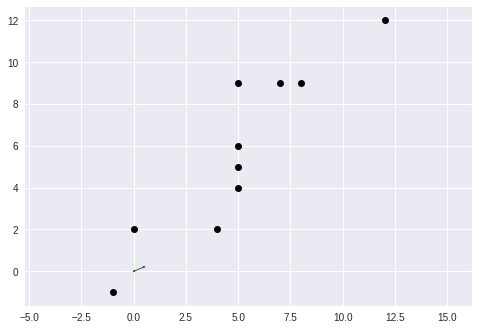

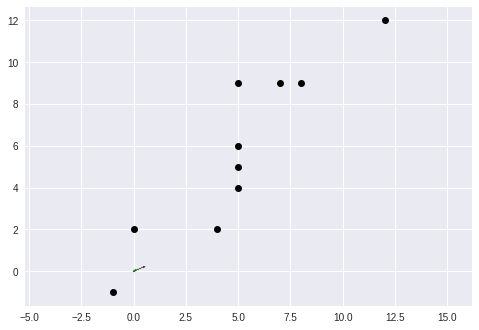

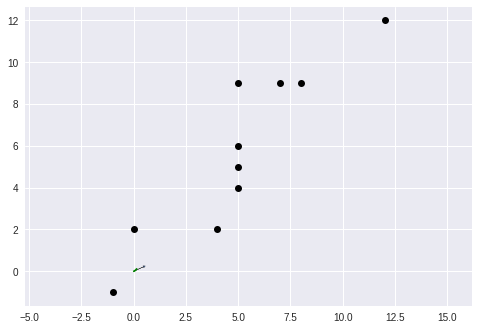

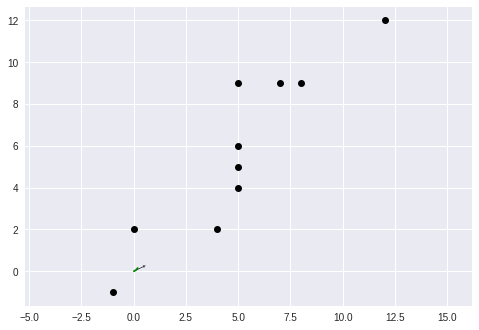

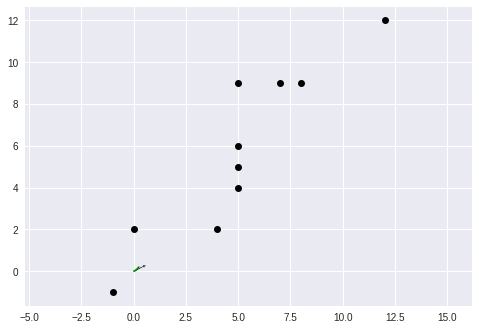

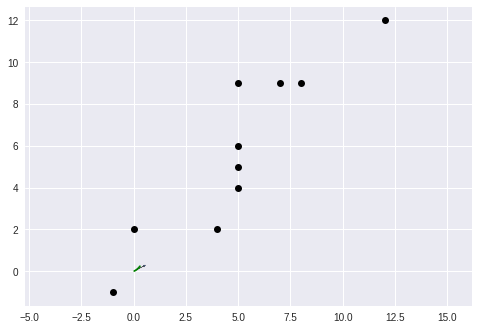

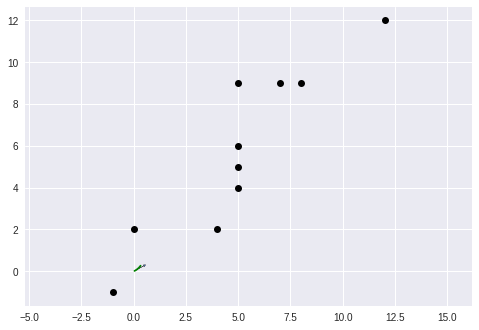

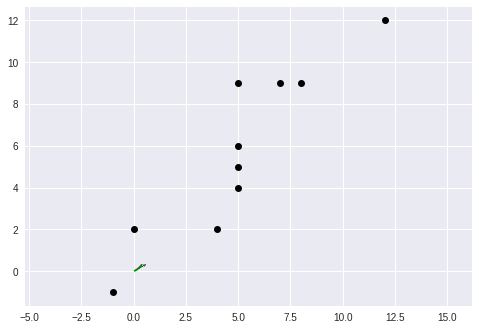

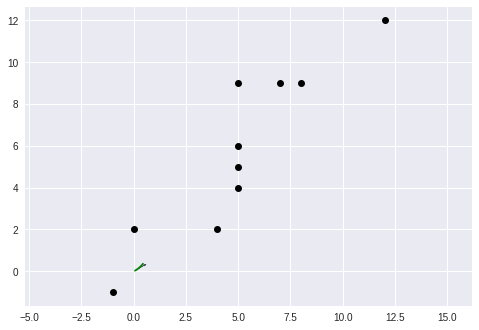

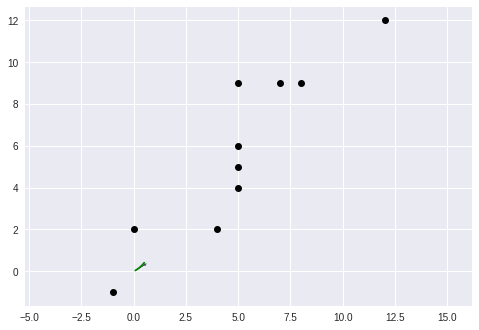

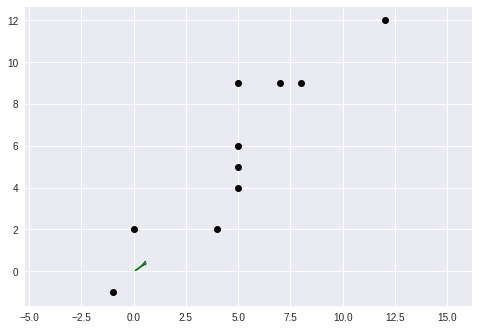

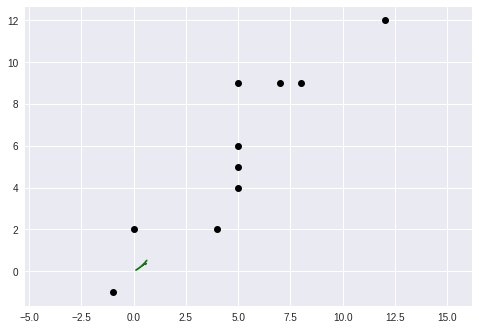

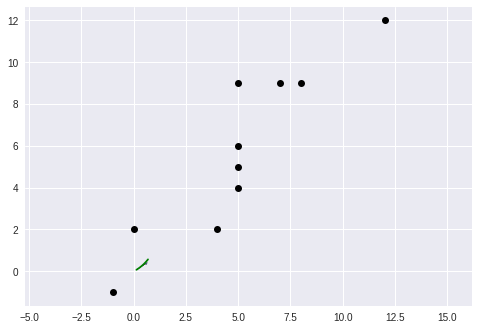

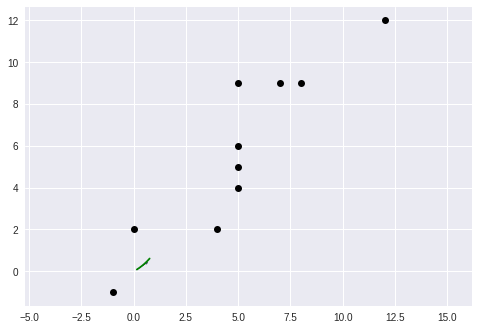

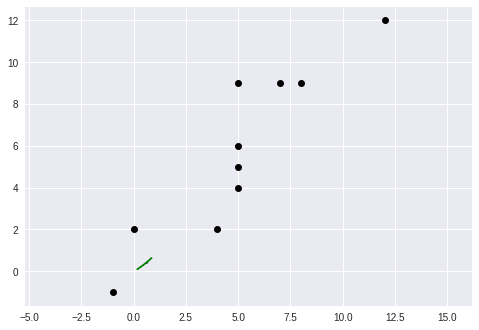

KeyboardInterrupt: ignored

In [13]:
def main():

    # initial state [x(m), y(m), yaw(rad), v(m/s), omega(rad/s)]
    
    x = np.array([0.0, 0.0, math.pi / 8.0, 0.0, 0.0])
    
    # goal position [x(m), y(m)]
    goal = np.array([10, 10])
    
    # obstacles [x(m) y(m), ....]
    ob = np.matrix([[-1, -1],
                    [0, 2],
                    [4.0, 2.0],
                    [5.0, 4.0],
                    [5.0, 5.0],
                    [5.0, 6.0],
                    [5.0, 9.0],
                    [8.0, 9.0],
                    [7.0, 9.0],
                    [12.0, 12.0]
                    ])
    

    u = np.array([0.0, 0.0])
    config = Config()
    traj = np.array(x)

    for i in range(1000):
        u, ltraj = dwa_control(x, u, config, goal, ob)

        x = motion(x, u, config.dt)
        traj = np.vstack((traj, x))  # store state history

        if plot_mission:
            plt.cla()
            plt.plot(ltraj[:, 0], ltraj[:, 1], "-g")
            plt.plot(x[0], x[1], "xr")
            plt.plot(goal[0], goal[1], "xb")
            plt.plot(ob[:, 0], ob[:, 1], "ok")
            plot_arrow(x[0], x[1], x[2])
            plt.axis("equal")
            plt.grid(True)
            plt.pause(0.0001)

        # check goal
        if math.sqrt((x[0] - goal[0])**2 + (x[1] - goal[1])**2) <= config.robot_radius:
            print("Goal!!")
            break

    print("Done")
    if plot_mission:
        plt.plot(traj[:, 0], traj[:, 1], "-r")
        plt.show()


if __name__ == '__main__':
    main()